Цель задания: изучить работу с готовыми моделями из torchvision.

Контекст
Вам необходимо подобрать базовую модель для работы по вашей задаче. Вы пробуете обучать различные модели на “ваших” данных. По результатам отберёте лучшую для дальнейшего обучения.

Задание
Вам необходимо провести эксперименты по начальному обучению различных моделей и сравнить результаты.

Возьмите датасет EMNIST из torchvision
Обучите на нём модели: ResNet 18, VGG 16, Inception v3, DenseNet 161 (с нуля по 10 эпох)
Сведите результаты обучения моделей (графики лоса) в таблицу и сравните их.
Задание со звездочкой*
Выполните то же задание, используя датасет hymenoptera_data

Инструкция к выполнению задания

Загрузите датасет, посмотрите примеры картинок в нём и проверьте наличествующие классы и их дисбаланс.
Создайте модель текущего типа, используя интерфейс torchvision для нужного количества классов.
Обучите модель с нуля 10 эпох. Фиксируйте значение функции потерь в список для последующего отображения.
Повторите пункты 2 и 3 для всех указанных вариантов моделей.
Формат сдачи работы
Прикрепите ссылку на готовое решение в личном кабинете. Работу можно отправлять в виде ссылки на python-ноутбук из GitHub, Google Colaboratory или аналогичных платформ. Не забудьте открыть доступ на просмотр и комментирование.

Критерии оценивания
По итогу выполнения задания вы получите зачёт.

Задание считается выполненным, если:

вы обучили каждую модель до некоторого улучшения качества
составлена таблица обучения для сравнения
Задание будет отправлено на доработку, если:

использованы не все типы моделей
не составлена сводная таблица с результатами

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import torch
from torch import nn
import torch.utils.data as data_utils
import torchvision as tv
from torchsummary import summary
import time

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline


Функции, которые помогут отслеживать память и сохранять промежуточные значения, чтобы не допустить превышения лимитов.

In [4]:
import inspect
import pickle
import os
import sys
base_dir = '/content/drive/MyDrive/tmp/'
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

def show_memory_usage(objs=locals().items()):
    for name, size in sorted(((name, sys.getsizeof(value)) for name, value in objs), key=lambda x: -x[1])[:10]:
        if name[0] != '_' and name not in ['rcParams', 'rcParamsDefault', 'rcParamsOrig', 'sctypeNA']:
            print(f"{name:>30}: {sizeof_fmt(size):>8}")

def save_pickle(obj, fname, dir=base_dir):
    full_fname = dir + '/' + fname
    with open(full_fname, 'wb') as pickle_file:
        pickle.dump(obj, pickle_file)
    print(f"saved \"{fname}\" ({sizeof_fmt(os.path.getsize(full_fname))}).")

def load_pickle(fname, dir=base_dir):
    full_fname = dir + '/' + fname
    with open(full_fname, 'rb') as pickle_file:
        obj = pickle.load(pickle_file)
    print(f"loaded \"{fname}\" ({sizeof_fmt(os.path.getsize(full_fname))}).")
    return obj

In [5]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0, 0
    net.eval()
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [6]:
def train(net_name, net, train_iter, test_iter, trainer, num_epochs):
    Loss_train_list = []
    Accuracy_train_list = []
    Accuracy_test_list = []

    net.to(device)
    loss = nn.CrossEntropyLoss(reduction='sum') # используем категорийную кроссэнтропию и суммируем ошибки - чтобы сильнее их выделить
    net.train() # переключаем сеть в режим обучения
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()

        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            y_hat = net(X)
            #print(f'y_hat: {y_hat.size}, y: [y.size]')
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]

            if i % 10 == 0:
              print(f"Step {i}. time since epoch: {time.time() -  start:.3f}. "
                    f"Train acc: {train_acc_sum / n:.3f}. Train Loss: {train_l_sum / n:.3f}")
        test_acc = evaluate_accuracy(test_iter, net.to(device)) # считаем аккураси на тестовых данных
        print('-' * 20)
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}'
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')

        Loss_train_list.append(train_l_sum / n)
        Accuracy_train_list.append(train_acc_sum / n)
        Accuracy_test_list.append(test_acc)

    x1 = range(0, num_epochs)
    x2 = range(0, num_epochs)
    x3 = range(0, num_epochs)
    y1 = Loss_train_list
    y2 = Accuracy_train_list
    y3 = Accuracy_test_list
    #print(f'')
    fig, ax = plt.subplots(3,1)
    fig.set_figwidth(6)
    fig.set_figheight(12)
    fig.suptitle('loss & accuracy')
    ax[0].plot(x1, y1, 'o-')
    ax[0].set_xlabel('train loss vs. epoches')
    ax[0].set_ylabel('train loss')
    ax[1].plot(x2, y2, '.-')
    ax[1].set_xlabel('train accuracy vs. epoches')
    ax[1].set_ylabel('train accuracy')
    ax[2].plot(x3, y3, '.-')
    ax[2].set_xlabel('test accuracy vs. epoches')
    ax[2].set_ylabel('test accuracy')
    plt.show()
    path_png = "/content/drive/MyDrive/tmp/" + net_name + ".png"
    fig.savefig(path_png, format='png')

    save_pickle(Loss_train_list,net_name + '_' + 'Loss_train_list' + '.pickle',base_dir)
    save_pickle(Accuracy_train_list,net_name + '_' + 'Accuracy_train_list' + '.pickle',base_dir)
    save_pickle(Accuracy_test_list,net_name + '_' + 'Accuracy_test_list' + '.pickle',base_dir)

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## DataSet

EMNIST ByClass: 697 932 characters. 62 unbalanced classes.

EMNIST ByMerge: 697 932 characters. 47 unbalanced classes.

EMNIST Balanced: 112 800 characters. 47 balanced classes.

EMNIST Letters: 124 800 characters. 26 balanced classes.

EMNIST Digits: 240 000 characters. 10 balanced classes.

EMNIST MNIST: 60 000 characters. 10 balanced classes.

<font color=green size=3>
Видим, что полных набора 3.
<br>
Из них:
<br>
<br>
EMNIST Balanced - специально сбалансированный, для облегчения обучения.
<br>
EMNIST ByClass - самый полный  и несбалансированный.
<br>
Будем использовать и тот и другой, чтобы посмотреть на разницу для обучения.
<br>
</font>

In [8]:
BATCH_SIZE = 256
indices = torch.arange(112800)

transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3), # предобученные модели работают с 3х канальными рисунками, поэтому искусственно делаем из одного три канала
    tv.transforms.Resize((224, 224)), # трансформируем наши изображения до требуемого размера
    tv.transforms.ToTensor()
])
train_dataset_bc = tv.datasets.EMNIST(root="./data", split='byclass', train=True, transform=transoforms, download=True)
test_dataset_bc = tv.datasets.EMNIST(root="./data", split='byclass', train=False, transform=transoforms, download=True)

train_dataset_bc_min = data_utils.Subset(train_dataset_bc, indices)
test_dataset_bc_min = data_utils.Subset(test_dataset_bc, indices)
train_iter_bc = torch.utils.data.DataLoader(train_dataset_bc_min, batch_size=BATCH_SIZE)
test_iter_bc = torch.utils.data.DataLoader(test_dataset_bc_min, batch_size=BATCH_SIZE)
# уменьшаем выборку данных, чтобы протестировать код на cpu быстрее
# 112800 ограничили количеством в сбалансированном датасете

#train_iter_bc = torch.utils.data.DataLoader(train_dataset_bc, batch_size=BATCH_SIZE)
#test_iter_bc = torch.utils.data.DataLoader(test_dataset_bc, batch_size=BATCH_SIZE)

#############################################3

train_dataset_bl = tv.datasets.EMNIST(root="./data", split='balanced', train=True, transform=transoforms, download=True)
test_dataset_bl = tv.datasets.EMNIST(root="./data", split='balanced', train=False, transform=transoforms, download=True)

#train_dataset_bl_min = data_utils.Subset(train_dataset_bl, indices)
#test_dataset_bl_min = data_utils.Subset(test_dataset_bl, indices)
#train_iter_bl = torch.utils.data.DataLoader(train_dataset_bl_min, batch_size=BATCH_SIZE)
#test_iter_bl = torch.utils.data.DataLoader(test_dataset_bl_min, batch_size=BATCH_SIZE)
# уменьшаем выборку данных, чтобы протестировать код на cpu быстрее


train_iter_bl = torch.utils.data.DataLoader(train_dataset_bl, batch_size=BATCH_SIZE)
test_iter_bl = torch.utils.data.DataLoader(test_dataset_bl, batch_size=BATCH_SIZE)

100%|██████████| 561753746/561753746 [00:28<00:00, 19805312.23it/s]


Extracting ./data/EMNIST/raw/gzip.zip to ./data/EMNIST/raw


In [9]:
#(X,y) =
train_iter_bc.dataset

<font color=green size=3>
DenseNet 161 feature extraction  
<br>
EMNIST ByClass
<br>
</font>

In [10]:
model_name = 'model_densenet161_bc'
model_densenet161_bc = tv.models.densenet161(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:01<00:00, 90.2MB/s]


In [11]:
model_densenet161_bc = model_densenet161_bc.to(device)

In [12]:
print(model_densenet161_bc)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [13]:
#summary(model_densenet161_bc.to(device), input_size=(3, 224, 224)) # проверяем размерности архитектуры

In [14]:
#x = torch.rand(4, 3, 224, 224).to(device)
#out = model_densenet161_bc.forward(x)

In [15]:
# Убираем требование градиента:
for param in model_densenet161_bc.parameters():
    param.requires_grad = False # Замораживаем веса. Мы их менять не будем.

In [16]:
model_densenet161_bc.classifier = nn.Linear(in_features=2208, out_features=62).to(device)

In [17]:
print("Params to learn:") # выпишем в список, какие параметры будут дообучаться (изменяться под новую задачу)
params_to_update = []
for name, param in model_densenet161_bc.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 classifier.weight
	 classifier.bias


Step 0. time since epoch: 10.084. Train acc: 0.008. Train Loss: 4.230
Step 10. time since epoch: 32.881. Train acc: 0.051. Train Loss: 4.023
Step 20. time since epoch: 55.503. Train acc: 0.073. Train Loss: 3.884
Step 30. time since epoch: 78.539. Train acc: 0.076. Train Loss: 3.804
Step 40. time since epoch: 102.280. Train acc: 0.091. Train Loss: 3.743
Step 50. time since epoch: 126.219. Train acc: 0.107. Train Loss: 3.697
Step 60. time since epoch: 149.878. Train acc: 0.127. Train Loss: 3.651
Step 70. time since epoch: 173.463. Train acc: 0.149. Train Loss: 3.606
Step 80. time since epoch: 197.318. Train acc: 0.169. Train Loss: 3.566
Step 90. time since epoch: 221.237. Train acc: 0.187. Train Loss: 3.526
Step 100. time since epoch: 245.003. Train acc: 0.204. Train Loss: 3.492
Step 110. time since epoch: 268.881. Train acc: 0.219. Train Loss: 3.459
Step 120. time since epoch: 292.434. Train acc: 0.234. Train Loss: 3.427
Step 130. time since epoch: 316.313. Train acc: 0.247. Train Loss:

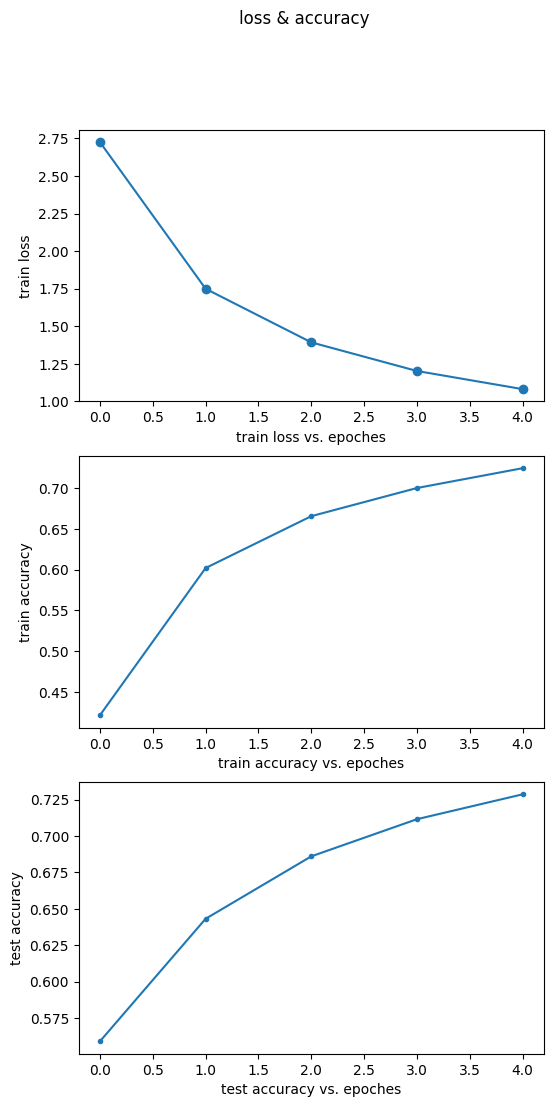

saved "model_densenet161_bc_Loss_train_list.pickle" (61.0 B).
saved "model_densenet161_bc_Accuracy_train_list.pickle" (61.0 B).
saved "model_densenet161_bc_Accuracy_test_list.pickle" (61.0 B).
CPU times: user 2h 20min 48s, sys: 7min 15s, total: 2h 28min 4s
Wall time: 2h 28min 47s


In [18]:
%%time
lr, num_epochs = 0.0001, 5
trainer = torch.optim.Adam(params_to_update, lr=lr)
train(model_name, model_densenet161_bc, train_iter_bc, test_iter_bc, trainer, num_epochs)

In [19]:
path_model = base_dir + model_name + '.pt'
torch.save(model_densenet161_bc.state_dict(), path_model)

In [31]:
torch.cuda.empty_cache()

<font color=green size=3>
DenseNet 161 feature extraction  
<br>
EMNIST Balanced
<br>
</font>

In [42]:
model_name = 'model_densenet161_bl'
model_densenet161_bl = tv.models.densenet161(pretrained=True)

In [43]:
model_densenet161_bl = model_densenet161_bl.to(device)

In [44]:
print(model_densenet161_bl)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [45]:
#summary(model_densenet161_bl.to(device), input_size=(3, 224, 224)) # проверяем размерности архитектуры

In [46]:
# Убираем требование градиента:
for param in model_densenet161_bl.parameters():
    param.requires_grad = False # Замораживаем веса. Мы их менять не будем.

In [47]:
model_densenet161_bl.classifier = nn.Linear(in_features=2208, out_features=47).to(device)

In [48]:
print("Params to learn:") # выпишем в список, какие параметры будут дообучаться (изменяться под новую задачу)
params_to_update = []
for name, param in model_densenet161_bl.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 classifier.weight
	 classifier.bias


Step 0. time since epoch: 2.354. Train acc: 0.012. Train Loss: 3.919
Step 10. time since epoch: 26.621. Train acc: 0.023. Train Loss: 3.867
Step 20. time since epoch: 50.333. Train acc: 0.031. Train Loss: 3.826
Step 30. time since epoch: 74.205. Train acc: 0.045. Train Loss: 3.793
Step 40. time since epoch: 97.691. Train acc: 0.064. Train Loss: 3.761
Step 50. time since epoch: 121.724. Train acc: 0.085. Train Loss: 3.728
Step 60. time since epoch: 145.303. Train acc: 0.106. Train Loss: 3.695
Step 70. time since epoch: 169.124. Train acc: 0.125. Train Loss: 3.663
Step 80. time since epoch: 192.883. Train acc: 0.143. Train Loss: 3.632
Step 90. time since epoch: 216.726. Train acc: 0.160. Train Loss: 3.601
Step 100. time since epoch: 240.435. Train acc: 0.176. Train Loss: 3.571
Step 110. time since epoch: 264.213. Train acc: 0.191. Train Loss: 3.542
Step 120. time since epoch: 288.082. Train acc: 0.205. Train Loss: 3.514
Step 130. time since epoch: 311.793. Train acc: 0.217. Train Loss: 3

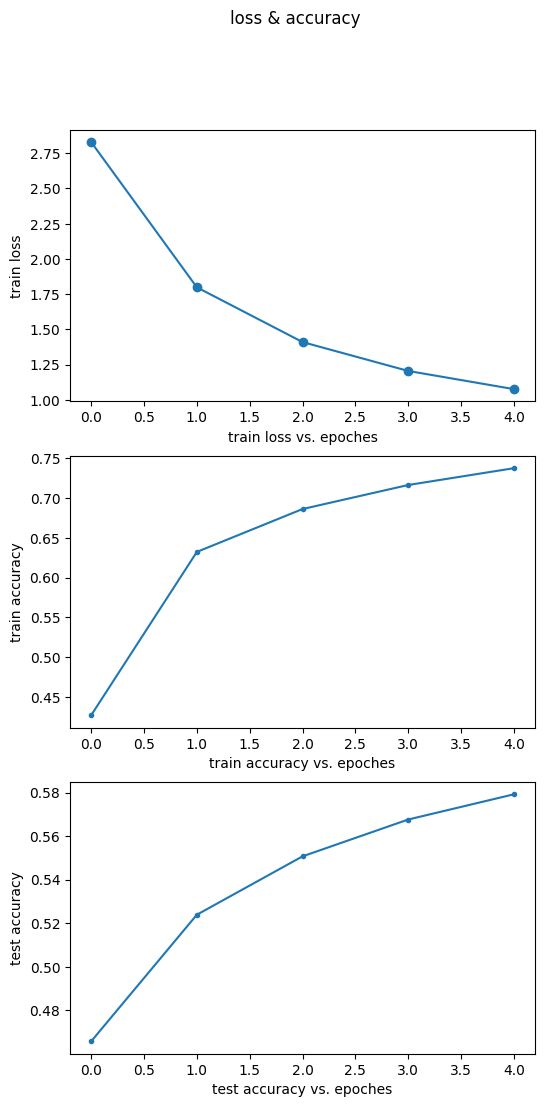

saved "model_densenet161_bl_Loss_train_list.pickle" (61.0 B).
saved "model_densenet161_bl_Accuracy_train_list.pickle" (61.0 B).
saved "model_densenet161_bl_Accuracy_test_list.pickle" (61.0 B).
CPU times: user 2h 20min 45s, sys: 7min 25s, total: 2h 28min 11s
Wall time: 2h 28min 43s


In [49]:
%%time
lr, num_epochs = 0.0001, 5
trainer = torch.optim.Adam(params_to_update, lr=lr)
train(model_name, model_densenet161_bl, train_iter_bl, test_iter_bc, trainer, num_epochs)

In [50]:
path_model = base_dir + model_name + '.pt'
torch.save(model_densenet161_bl.state_dict(), path_model)

In [51]:
torch.cuda.empty_cache()

<font color=green size=3>
Это шаблон примечания
<br>
<br>
</font>